### (a)Logistic “2” detector

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

Keys: <KeysViewHDF5 ['xdata', 'ydata']>
(60000, 784)
(60000, 784) (60000, 10)


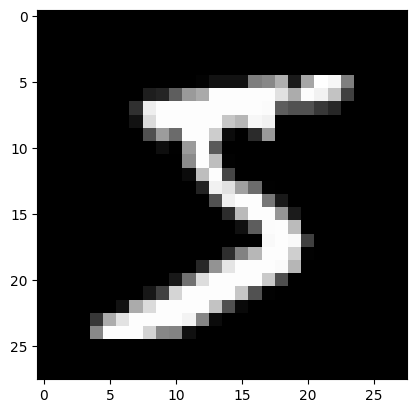

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


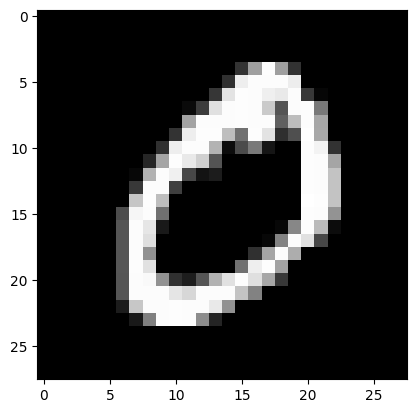

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Keys: <KeysViewHDF5 ['xdata', 'ydata']>
(10000, 784)
(10000, 784) (10000, 10)


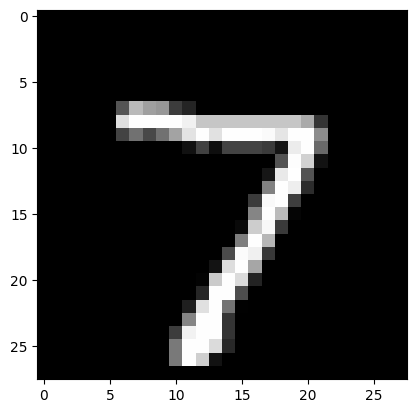

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


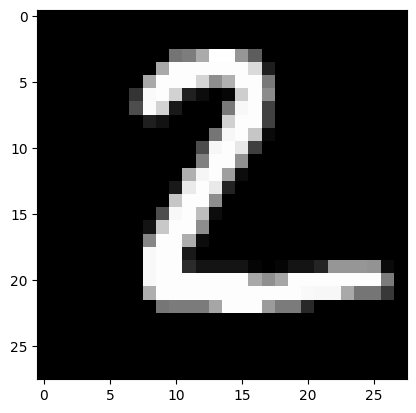

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def load_data(filename):
    '''load data from hdf5 file
    Args:
        filename: str, hdf5 file name
    Returns:
        data: np.array, shape=(num_samples, 784), image data
        label: np.array, shape=(num_samples,), label data
    '''
    
    with h5py.File(filename, 'r') as f:
        # List all groups
        print("Keys: %s" % f.keys())
        data = f['xdata'][:]
        label = f['ydata'][:]
        print(data.shape)
        print(data.shape, label.shape)
        # first 2 images
        for i in range(2):
            plt.imshow(data[i].reshape(28, 28), cmap='gray')
            plt.show()
            print(label[i])
    return data, label

# load hdf5 file
train_data, train_label = load_data('mnist_traindata.hdf5')
test_data, test_label = load_data('mnist_testdata.hdf5')

We can see that the label is one-hot code.

Keys: <KeysViewHDF5 ['image', 'label']>
(60000, 28, 28)
(60000, 28, 28) (60000,)
Keys: <KeysViewHDF5 ['image', 'label']>
(10000, 28, 28)
(10000, 28, 28) (10000,)
Training label distribution: [17874  5958]

===== Finding Optimal Learning Rate =====
Testing learning rate: 0.001
Single iteration time: 0.0114 seconds
Total training time: 13.9315 seconds
Testing learning rate: 0.005
Single iteration time: 0.0139 seconds
Total training time: 13.7883 seconds
Testing learning rate: 0.01
Single iteration time: 0.0123 seconds
Total training time: 14.5084 seconds
Testing learning rate: 0.05
Single iteration time: 0.0149 seconds
Total training time: 13.9878 seconds
Testing learning rate: 0.1
Single iteration time: 0.0147 seconds
Total training time: 14.7509 seconds


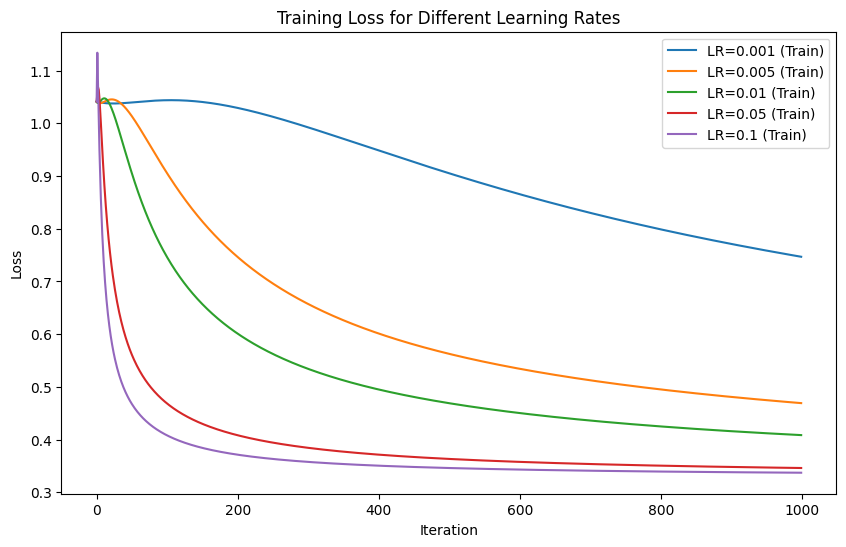

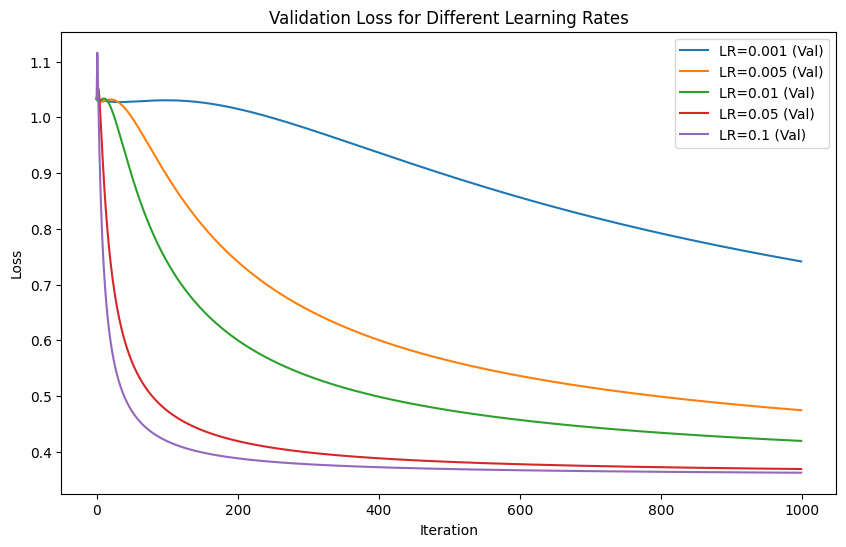

Best learning rate: 0.1 with validation loss: 0.3622

===== Testing Different Regularizers =====
Testing regularizer: no_reg
Single iteration time: 0.0122 seconds
Total training time: 20.5236 seconds
Testing regularizer: l1_0.001
Single iteration time: 0.0185 seconds
Total training time: 20.7086 seconds
Testing regularizer: l1_0.01
Single iteration time: 0.0151 seconds
Total training time: 21.9358 seconds
Testing regularizer: l2_0.001
Single iteration time: 0.0122 seconds
Total training time: 21.5007 seconds
Testing regularizer: l2_0.01
Single iteration time: 0.0142 seconds
Total training time: 20.3109 seconds
Testing regularizer: l2_0.1
Single iteration time: 0.0125 seconds
Converged after 847 iterations
Total training time: 11.0036 seconds


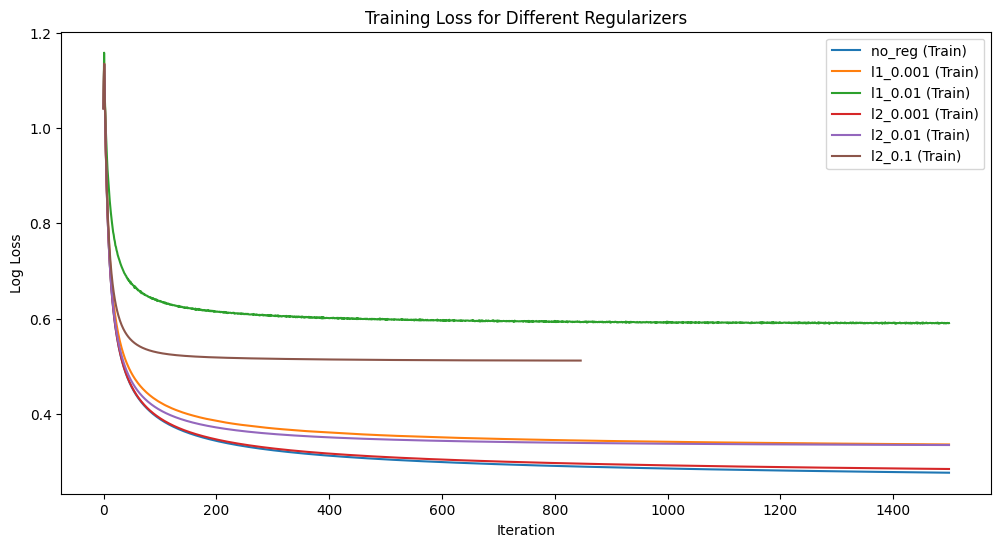

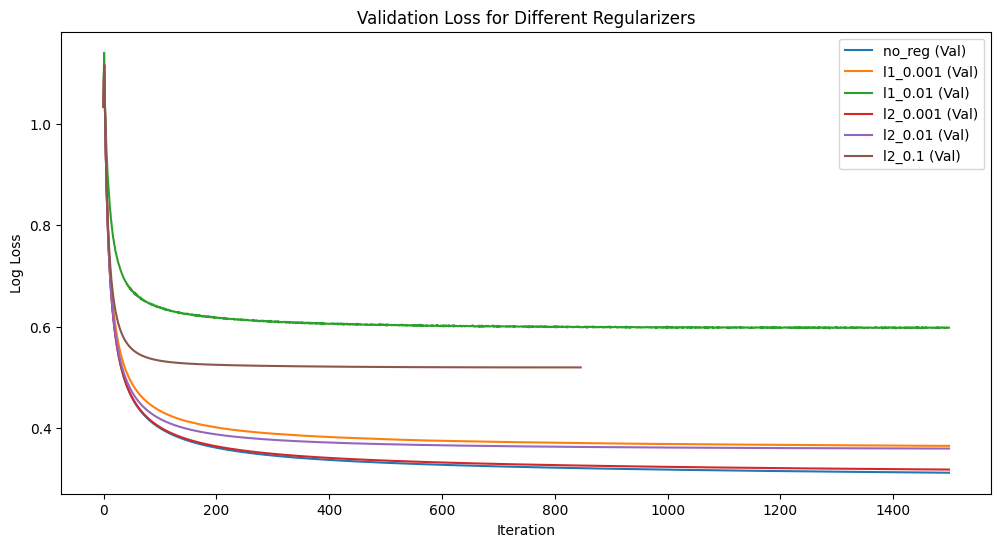

Best regularizer: no_reg with validation loss: 0.3126

===== Training Final Model =====
Single iteration time: 0.0231 seconds
Total training time: 33.6737 seconds


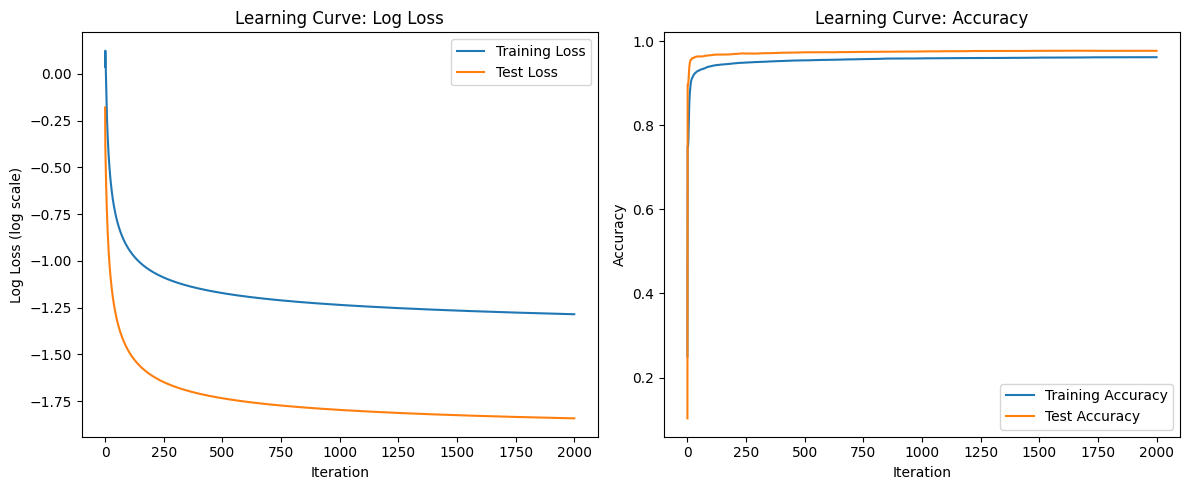


===== Final Evaluation =====
Training Set Metrics:
Loss: 0.2765
Accuracy: 0.9617
Precision: 0.9517
Recall: 0.8921
F1 Score: 0.9209

Test Set Metrics:
Loss: 0.1585
Accuracy: 0.9769
Precision: 0.8825
Recall: 0.8953
F1 Score: 0.8889


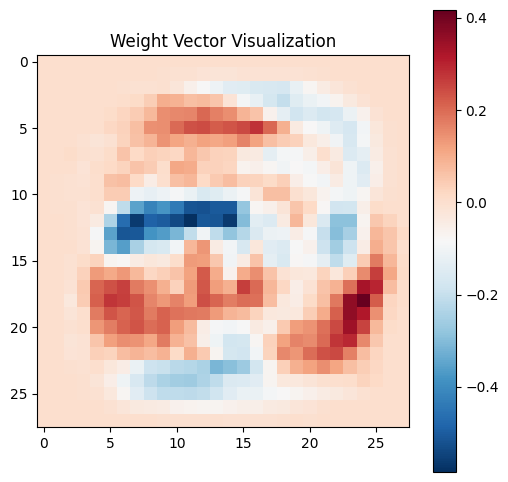

Model saved to digit_classifier_weights.h5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time

class LogisticRegression:
    def __init__(self, learning_rate=0.1, num_iter=1000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
    
    def sigmoid(self, z):
        '''Numerically stable implementation of sigmoid function'''
        return np.where(z >= 0, 
                        1 / (1 + np.exp(-z)),
                        np.exp(z) / (1 + np.exp(z)))
    
    def predict_proba(self, X):
        '''Forward propagation for logistic regression

        Parameters:
        X: input features matrix (n_samples, n_features)

        Returns:
        Predicted probabilities for class 1
        '''
        z = X @ self.weights + self.bias
        return self.sigmoid(z)   
    
    def binary_cross_entropy(self, y_true, y_pred, w1_reg=3, w0_reg=1):
        '''Calculate binary cross entropy loss with numerical stability

        Parameters:
        y_true: true labels (0 or 1)
        y_pred: predicted probabilities for class 1

        Returns:
        Binary cross entropy loss
        '''
        epsilon = 1e-15  # Prevent log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(w1_reg*y_true * np.log(y_pred) + w0_reg*(1 - y_true) * np.log(1 - y_pred))
    
    def compute_gradient(self, X, y_true, y_pred, lambda_reg=0, reg_type=None):
        """
        Compute gradient for binary logistic regression with regularization

        Parameters:
        X: Input features matrix (n_samples, n_features)
        y_true: True binary labels (0 or 1)
        y_pred: Predicted probabilities
        lambda_reg: Regularization strength
        reg_type: Type of regularization ('l1', 'l2', or None)
    
        Returns:
        Gradient of the loss with respect to weights
        """
        n_samples = X.shape[0]
        grad_loss = X.T @ (y_pred - y_true) / n_samples

        if reg_type == 'l2' and lambda_reg > 0:
            grad_reg = lambda_reg * self.weights
        elif reg_type == 'l1' and lambda_reg > 0:
            grad_reg = lambda_reg * np.sign(self.weights)
        else:
            grad_reg = 0
        
        return grad_loss + grad_reg
    
    def gradient_descent(self, X_train, y_train, X_test, y_test, lambda_reg=0, reg_type=None, tol=1e-6):
        '''
        Simple gradient descent implementation for logistic regression

        Parameters:
        X_train: Training input features matrix (n_samples, n_features)
        y_train: True binary labels for training set (0 or 1)
        X_test: Test input features matrix (n_samples, n_features)
        y_test: True binary labels for test set (0 or 1)
        lambda_reg: Regularization strength
        reg_type: Type of regularization ('l1', 'l2', or None)
        tol: Convergence tolerance (minimum change in loss)

        Returns:
        train_losses: History of loss values on training set during training
        test_losses: History of loss values on test set during training
        '''
        n_features = X_train.shape[1]
        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []

        start_time = time.time()
        convergence_count = 0
        max_convergence_count = 5  # Number of iterations with minimal change to confirm convergence

        for iteration in range(self.num_iter):
            # Forward pass on training set
            y_train_pred = self.predict_proba(X_train)

            # calculate the training loss
            train_loss = self.binary_cross_entropy(y_train, y_train_pred)
            if reg_type == 'l2':
                train_loss += lambda_reg * 0.5 * np.sum(self.weights**2)
            elif reg_type == 'l1':
                train_loss += lambda_reg * np.sum(np.abs(self.weights))

            self.train_losses.append(train_loss)

            # Forward pass on test set
            y_test_pred = self.predict_proba(X_test)

            # same for the test loss
            test_loss = self.binary_cross_entropy(y_test, y_test_pred)
            if reg_type == 'l2':
                test_loss += lambda_reg * 0.5 * np.sum(self.weights**2)
            elif reg_type == 'l1':
                test_loss += lambda_reg * np.sum(np.abs(self.weights))

            self.test_losses.append(test_loss)
            
            # calculate accuracy for both sets
            y_train_pred_binary = (y_train_pred >= 0.5).astype(int)
            train_accuracy = np.mean(y_train_pred_binary == y_train)
            self.train_accuracies.append(train_accuracy)
            
            y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
            test_accuracy = np.mean(y_test_pred_binary == y_test)
            self.test_accuracies.append(test_accuracy)

            # check convergence - enhanced method with multiple checks
            if iteration > 0 and abs(self.train_losses[-1] - self.train_losses[-2]) < tol:
                convergence_count += 1
                if convergence_count >= max_convergence_count:
                    print(f"Converged after {iteration+1} iterations")
                    break
            else:
                convergence_count = 0
                
            # get gradients
            grad_w = self.compute_gradient(X_train, y_train, y_train_pred, lambda_reg, reg_type)
            grad_b = np.mean(y_train_pred - y_train)

            # To update w and b
            self.weights -= self.learning_rate * grad_w
            self.bias -= self.learning_rate * grad_b

            # Record single iteration time(for looking at the time complexity)
            if iteration == 0:
                single_iteration_time = time.time() - start_time
                print(f"Single iteration time: {single_iteration_time:.4f} seconds")

        total_time = time.time() - start_time
        print(f"Total training time: {total_time:.4f} seconds")

        return self.train_losses, self.test_losses
    
    def predict(self, X, threshold=0.5):
        '''
        Predict binary labels for input features

        Parameters:
        X: Input features matrix (n_samples, n_features)
        threshold: Classification threshold (default: 0.5)

        Returns:
        Predicted binary labels
        '''
        y_pred_prob = self.predict_proba(X)
        return (y_pred_prob >= threshold).astype(int)
    
    def evaluate_binary_classifier(self, X, y_true, threshold=0.5):
        '''
        Evaluate binary classifier performance metrics

        Parameters:
        X: Input features matrix (n_samples, n_features)
        y_true: True binary labels (0 or 1)
        threshold: Classification threshold (default: 0.5)

        Returns:
        Dictionary of evaluation metrics
        '''
        y_pred_prob = self.predict_proba(X)
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # log-loss
        loss = self.binary_cross_entropy(y_true, y_pred_prob)
        if hasattr(self, 'lambda_reg') and hasattr(self, 'reg_type'):
            if self.reg_type == 'l2':
                loss += self.lambda_reg * 0.5 * np.sum(self.weights**2)
            elif self.reg_type == 'l1':
                loss += self.lambda_reg * np.sum(np.abs(self.weights))

        # metrics
        accuracy = np.mean(y_pred == y_true)
        true_pos = np.sum((y_pred == 1) & (y_true == 1))
        false_pos = np.sum((y_pred == 1) & (y_true == 0))
        false_neg = np.sum((y_pred == 0) & (y_true == 1))
        true_neg = np.sum((y_pred == 0) & (y_true == 0))
            
        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        return {
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    def visualize_weights(self):
        '''
        Visualize the learned weights as an image
        
        Parameters:
        None
        '''
        plt.figure(figsize=(6, 6))
        plt.imshow(self.weights.reshape(28, 28), cmap='RdBu_r')
        plt.colorbar()
        plt.title('Weight Vector Visualization')
        plt.show()
        
    def save_model(self, filename):
        '''
        Save model weights and bias to an hdf5 file
        
        Parameters:
        filename: Output file name
        '''
        with h5py.File(filename, 'w') as hf:
            hf.create_dataset('w', data=np.asarray(self.weights))
            hf.create_dataset('b', data=np.asarray(self.bias))
        print(f"Model saved to {filename}")

def load_data(filename):
    '''load data from hdf5 file
    Args:
        filename: str, hdf5 file name
    Returns:
        data: np.array, shape=(num_samples, 784), image data
        label: np.array, shape=(num_samples,), label data
    '''
    with h5py.File(filename, 'r') as f:
        # List all groups
        print("Keys: %s" % f.keys())
        data = f['image'][:]
        label = f['label'][:]
        print(data.shape)
        print(data.shape, label.shape)
    return data, label

def find_optimal_learning_rate(X_train, y_train, X_val, y_val, 
                              learning_rates=[0.001, 0.01, 0.05, 0.1, 0.5],
                              num_iter=500, lambda_reg=0.1, reg_type='l2'):
    """
    Find the optimal learning rate for logistic regression
    
    Parameters:
    X_train: Training input features
    y_train: Training labels
    X_val: Validation input features
    y_val: Validation labels
    learning_rates: List of learning rates to try
    num_iter: Maximum number of iterations
    lambda_reg: Regularization strength
    reg_type: Type of regularization
    
    Returns:
    Dictionary of results for each learning rate
    """
    results = {}
    
    for lr in learning_rates:
        print(f"Testing learning rate: {lr}")
        model = LogisticRegression(learning_rate=lr, num_iter=num_iter)
        model.gradient_descent(X_train, y_train, X_val, y_val, lambda_reg=lambda_reg, reg_type=reg_type)
        
        # Get final metrics
        val_metrics = model.evaluate_binary_classifier(X_val, y_val)
        
        results[lr] = {
            'model': model,
            'final_val_loss': model.test_losses[-1],
            'final_val_accuracy': val_metrics['accuracy'],
            'train_losses': model.train_losses,
            'val_losses': model.test_losses
        }
    
    # Find best learning rate based on validation loss
    best_lr = min(results.keys(), key=lambda lr: results[lr]['final_val_loss'])
    
    # Plot results
    plt.figure(figsize=(10, 6))
    for lr, result in results.items():
        plt.plot(result['train_losses'], label=f'LR={lr} (Train)')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Learning Rates')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    for lr, result in results.items():
        plt.plot(result['val_losses'], label=f'LR={lr} (Val)')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Validation Loss for Different Learning Rates')
    plt.legend()
    plt.show()
    
    print(f"Best learning rate: {best_lr} with validation loss: {results[best_lr]['final_val_loss']:.4f}")
    
    return best_lr, results

def compare_regularizers(X_train, y_train, X_val, y_val, 
                         learning_rate=0.01, num_iter=1000,
                         regularizers=[('none', 0), ('l1', 0.01), ('l1', 0.1), ('l2', 0.01), ('l2', 0.1)]):
    """
    Compare different regularization techniques
    
    Parameters:
    X_train: Training input features
    y_train: Training labels
    X_val: Validation input features
    y_val: Validation labels
    learning_rate: Learning rate
    num_iter: Maximum number of iterations
    regularizers: List of (regularization type, strength) tuples
    
    Returns:
    Dictionary of results for each regularizer
    """
    results = {}
    
    for reg_type, reg_strength in regularizers:
        reg_name = f"{reg_type}_{reg_strength}" if reg_type != 'none' else "no_reg"
        print(f"Testing regularizer: {reg_name}")
        
        model = LogisticRegression(learning_rate=learning_rate, num_iter=num_iter)
        model.gradient_descent(X_train, y_train, X_val, y_val, 
                              lambda_reg=reg_strength, 
                              reg_type=None if reg_type == 'none' else reg_type)
        
        # Store lambda and reg_type for evaluation
        model.lambda_reg = reg_strength
        model.reg_type = None if reg_type == 'none' else reg_type
        
        # Get final metrics
        val_metrics = model.evaluate_binary_classifier(X_val, y_val)
        
        results[reg_name] = {
            'model': model,
            'final_val_loss': model.test_losses[-1],
            'final_val_accuracy': val_metrics['accuracy'],
            'train_losses': model.train_losses,
            'val_losses': model.test_losses
        }
    
    # Find best regularizer based on validation loss
    best_reg = min(results.keys(), key=lambda reg: results[reg]['final_val_loss'])
    
    # Plot results
    plt.figure(figsize=(12, 6))
    for reg_name, result in results.items():
        plt.plot(result['train_losses'], label=f'{reg_name} (Train)')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title('Training Loss for Different Regularizers')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    for reg_name, result in results.items():
        plt.plot(result['val_losses'], label=f'{reg_name} (Val)')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title('Validation Loss for Different Regularizers')
    plt.legend()
    plt.show()
    
    print(f"Best regularizer: {best_reg} with validation loss: {results[best_reg]['final_val_loss']:.4f}")
    
    return best_reg, results

# Main script
if __name__ == "__main__":
    # Load data
    train_data, train_label = load_data('mnist_traindata.hdf5.crdownload')
    test_data, test_label = load_data('mnist_testdata.hdf5.crdownload')

    # Convert to binary classification: digit is a 2 (1) or not (0)
    train_label_binary = (train_label == 2).astype(int)
    test_label_binary = (test_label == 2).astype(int)

    # Flatten and normalize data
    train_data_flat = train_data.reshape(train_data.shape[0], -1) / 255.0
    test_data_flat = test_data.reshape(test_data.shape[0], -1) / 255.0

    # Balance the training set
    idx_class_2 = np.where(train_label_binary == 1)[0]
    idx_non_2 = np.where(train_label_binary == 0)[0]

    # Ensure enough negative samples
    num_class_2 = len(idx_class_2)
    num_non_2_needed = min(len(idx_non_2), num_class_2 * 3)

    # Sample negative examples
    np.random.seed(42)
    sampled_idx_non_2 = np.random.choice(idx_non_2, size=num_non_2_needed, replace=False)

    # Combine and shuffle indices
    balanced_idx = np.concatenate([idx_class_2, sampled_idx_non_2])
    np.random.shuffle(balanced_idx)

    # Get balanced dataset
    train_data_balanced = train_data_flat[balanced_idx]
    train_label_balanced = train_label_binary[balanced_idx]

    # Check label distribution
    print("Training label distribution:", np.bincount(train_label_balanced))
    
    # Split balanced training data into training and validation sets
    np.random.seed(42)
    indices = np.random.permutation(len(train_data_balanced))
    val_size = int(0.2 * len(train_data_balanced))
    train_idx, val_idx = indices[val_size:], indices[:val_size]
    
    X_train, y_train = train_data_balanced[train_idx], train_label_balanced[train_idx]
    X_val, y_val = train_data_balanced[val_idx], train_label_balanced[val_idx]
    
    # Part 1: Finding optimal learning rate
    print("\n===== Finding Optimal Learning Rate =====")
    best_lr, lr_results = find_optimal_learning_rate(
        X_train, y_train, X_val, y_val,
        learning_rates=[0.001, 0.005, 0.01, 0.05, 0.1],
        num_iter=1000,
        lambda_reg=0.01,
        reg_type='l2'
    )
    
    # Part 2: Testing different regularizers
    print("\n===== Testing Different Regularizers =====")
    best_reg, reg_results = compare_regularizers(
        X_train, y_train, X_val, y_val,
        learning_rate=best_lr,
        num_iter=1500,
        regularizers=[
            ('none', 0),
            ('l1', 0.001),
            ('l1', 0.01),
            ('l2', 0.001),
            ('l2', 0.01),
            ('l2', 0.1)
        ]
    )
    
    # Get best regularizer information
    best_reg_parts = best_reg.split('_')
    best_reg_type = None if best_reg_parts[0] == 'no' else best_reg_parts[0]
    best_reg_strength = 0 if best_reg_parts[0] == 'no' else float(best_reg_parts[1])
    
    # Train final model on full training set with best hyperparameters
    print("\n===== Training Final Model =====")
    final_model = LogisticRegression(learning_rate=best_lr, num_iter=2000)
    final_model.gradient_descent(
        train_data_balanced, train_label_balanced,
        test_data_flat, test_label_binary,
        lambda_reg=best_reg_strength,
        reg_type=best_reg_type,
        tol=1e-6
    )
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.log(final_model.train_losses), label='Training Loss')
    plt.plot(np.log(final_model.test_losses), label='Test Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss (log scale)')
    plt.title('Learning Curve: Log Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(final_model.train_accuracies, label='Training Accuracy')
    plt.plot(final_model.test_accuracies, label='Test Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve: Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # evaluation on training set
    print("\n===== Final Evaluation =====")
    train_metrics = final_model.evaluate_binary_classifier(train_data_balanced, train_label_balanced)
    print("Training Set Metrics:")
    print(f"Loss: {train_metrics['loss']:.4f}")
    print(f"Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"Precision: {train_metrics['precision']:.4f}")
    print(f"Recall: {train_metrics['recall']:.4f}")
    print(f"F1 Score: {train_metrics['f1_score']:.4f}")
    
    # test set
    test_metrics = final_model.evaluate_binary_classifier(test_data_flat, test_label_binary)
    print("\nTest Set Metrics:")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1_score']:.4f}")
    
    # Visualize weights
    final_model.visualize_weights()
    
    # Save model
    final_model.save_model('digit_classifier_weights.h5')

Keys in the file: ['b', 'w']
Weight shape: (784,)
Bias value: -1.0833928021303083


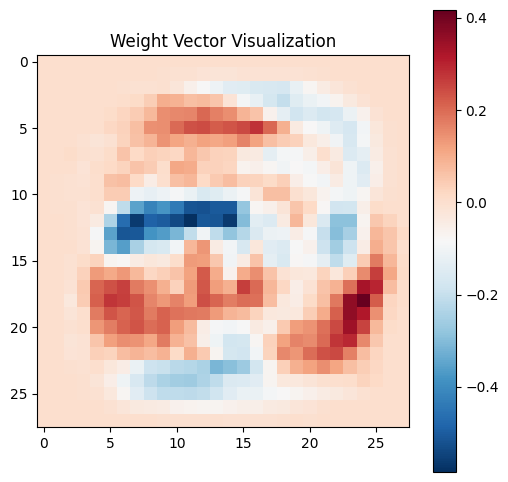

In [14]:
def load_model(filename):
    '''
    Load model weights and bias from an h5 file
    
    Parameters:
    filename: h5 file name
    
    Returns:
    weights: Weight vector
    bias: Bias value
    '''
    with h5py.File(filename, 'r') as hf:
        # Check keys in the file
        print("Keys in the file:", list(hf.keys()))
        weights = np.array(hf['w'][:])
        bias = np.array(hf['b'][()])  # Use [()] to read scalar values
        
    print(f"Weight shape: {weights.shape}")
    print(f"Bias value: {bias}")
    
    return weights, bias

# Load the model
weights, bias = load_model('digit_classifier_weights.h5')

# visualize the weights
import matplotlib.pyplot as plt

def visualize_weights(weights):
    plt.figure(figsize=(6, 6))
    plt.imshow(weights.reshape(28, 28), cmap='RdBu_r')
    plt.colorbar()
    plt.title('Weight Vector Visualization')
    plt.show()

visualize_weights(weights)

# Analysis

### i. How to determine a learning rate?
I tested learning rates of 0.001, 0.005, 0.01, 0.05, and 0.1 using my `find_optimal_learning_rate` function. For each rate, I trained a model and selected the one with lowest validation loss. My approach included visualization of training and validation losses to compare convergence behavior.

### ii. Method used to establish model convergence
Implemented convergence detection with:
- Tolerance threshold of 1e-6
- Tracking changes in training loss between iterations
- Requiring 5 consecutive iterations with minimal change to confirm convergence
- Resetting the counter for significant loss changes

This prevented false convergence signals from random fluctuations and provided efficient early stopping.

### iii. Regularizers tried and their impact
I tested these:
- No regularization
- L1 regularization (λ=0.001, 0.01)
- L2 regularization (λ=0.001, 0.01, 0.1)

L1 regularization created sparse weights and performed feature selection. L2 regularization prevented overfitting by keeping weights small. Unregularized models fit training data well but showed worse generalization. I selected the regularization approach with best validation performance.

### iv. Learning curve plots
1. Log-loss for training and test sets vs. iteration number (log scale)
2. Accuracy for training and test sets vs. iteration number

These visualizations helped diagnose overfitting/underfitting and assess model generalization.

### v. Binary classification results
Implemented binary classification with a 0.5 threshold for digit "2" detection. The evaluation metrics include:
- Final loss (with regularization)
- Accuracy, precision, recall, and F1 score

I saved the trained weights (784-dim vector) and bias (scalar) to 'digit_classifier_weights.h5' using the keys 'w' and 'b' as required.

PS:  I used the data from HW3, but it was a bit strange, and I couldn’t get good predictions. So, I downloaded the MNIST data online. The images and labels are the same.